In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

%matplotlib inline

In [3]:
#leo el dataframe
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [4]:
df.head(1)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers


In [5]:
#1. Crosstab Analysis
#Create a crosstab between the product category and the isBestSeller status.

crosstab = pd.crosstab(df['category'], df['isBestSeller'])
crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [6]:
#Are there categories where being a best-seller is more prevalent?

crosstab_sorted = crosstab.sort_values(by=True, ascending=False)
top_crosstab = crosstab_sorted.head(5)
top_crosstab

#Sí, Grocery, Health y personal Care, baby, deportes y exteriores y power y hand tools es en las que es más frecuente

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306


In [7]:
#2. Statistical Tests
# Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

from scipy.stats import chi2_contingency

In [8]:
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab)
chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [9]:
#hay una asociación altamente significativa entre las variables

In [10]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.

from scipy.stats.contingency import association

In [11]:
association(crosstab, method='cramer')

0.1222829439760564

In [12]:
#la asociación es débil según el método cramer's V effect size

<Axes: xlabel='category'>

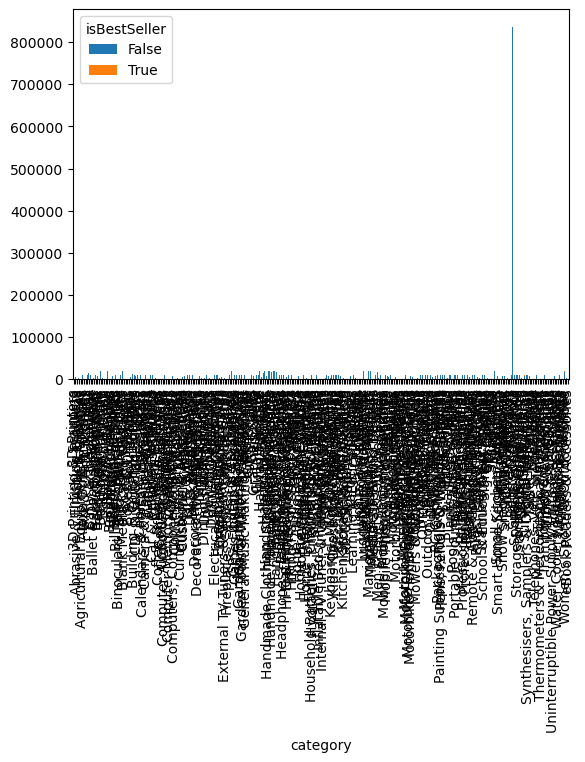

In [13]:
#3. Visualizations
#Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

crosstab.plot(kind='bar', stacked=True)

<Axes: xlabel='category'>

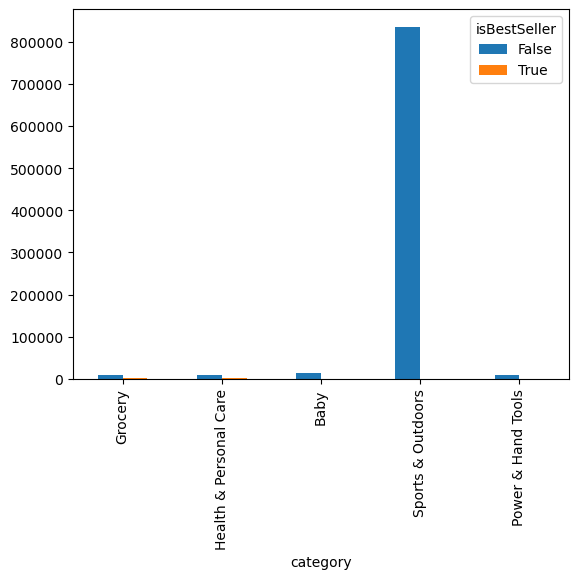

In [14]:
#Selecciono las 5 categorías más populares

top_crosstab.plot(kind='bar', stacked=False)

In [15]:
#PART 2
#Remove outliers in product prices.

#calculo el IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

In [16]:
#establezco los límites de los outliers
lower_bounds = Q1 - 1.5 * IQR
upper_bounds = Q3 + 1.5 * IQR

In [17]:
#identifico los outliers
price_without_outliers = df[(df['price'] >= lower_bounds) & (df['price'] <= upper_bounds)]
price_without_outliers.head(2)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers


In [18]:
#1. Violin plots
# Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.

#primero cuento las categorías
category_frequency = price_without_outliers['category'].value_counts()

#luego selecciono las 10 más comunes
top_category_frequency = category_frequency.head(20)

#creo el dataframe con las categorías más comunes
df_1 = price_without_outliers[price_without_outliers['category'].isin(top_category_frequency.index)]

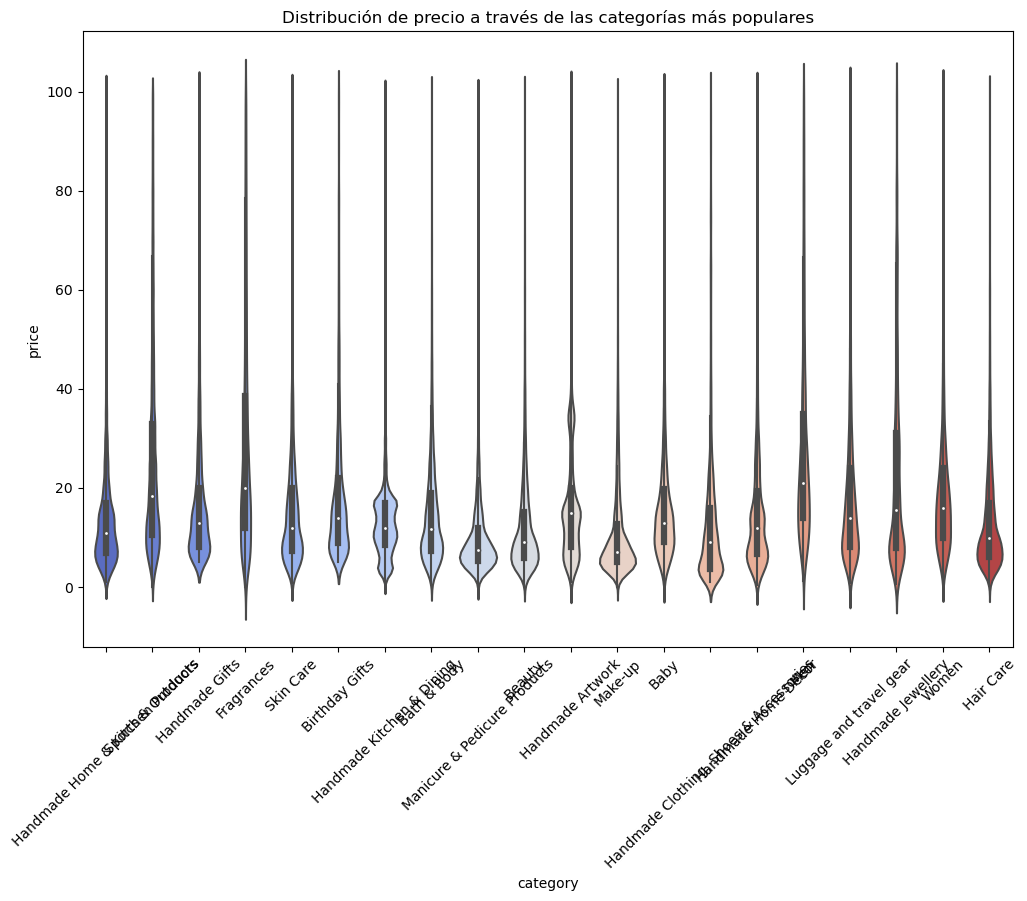

In [19]:
#creo el violin plot
plt.figure(figsize=(12,8))
sns.violinplot(data=df_1, x='category', y='price', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribución de precio a través de las categorías más populares')
plt.ylabel('price')
plt.xlabel('category')
plt.show()

In [20]:
#Which product category tends to have the highest median price? Don't filter here by top categories.

precio_mediana = price_without_outliers.groupby('category').agg({'price':'median'})

precio_mediana_mas_alto_por_categoria = precio_mediana.idxmax()
precio_mediana_mas_alto_por_valor = precio_mediana.max()

precio_mediana_mas_alto_por_categoria, precio_mediana_mas_alto_por_valor

(price    Desktop PCs
 dtype: object,
 price    74.0
 dtype: float64)

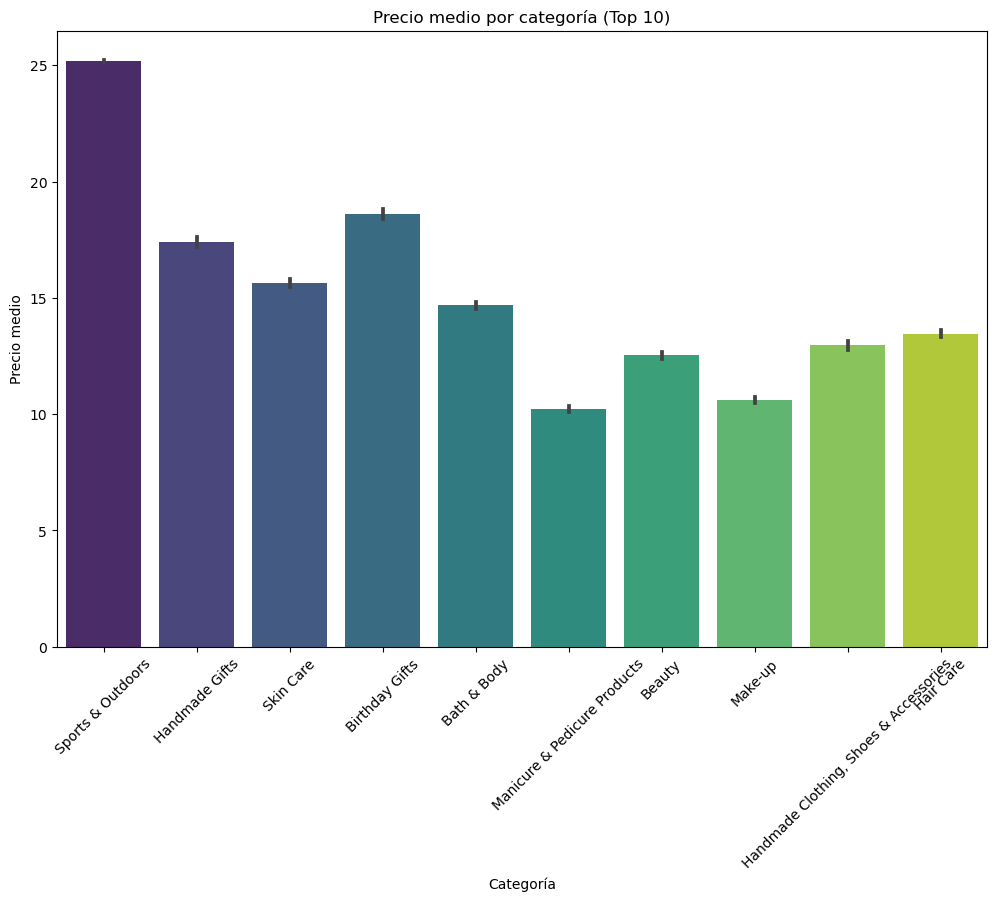

In [21]:
#2. Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

#luego selecciono las 10 más comunes
top_category_frequency_2 = category_frequency.head(10)

#creo el dataframe con las categorías más comunes
df_2 = price_without_outliers[price_without_outliers['category'].isin(top_category_frequency_2.index)]

plt.figure(figsize=(12, 8))
sns.barplot(x='category', y='price', data=df_2, palette='viridis')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje x para una mejor visualización
plt.title('Precio medio por categoría (Top 10)')
plt.xlabel('Categoría')
plt.ylabel('Precio medio')
plt.show()

In [22]:
#Which product category commands the highest average price? Don't filter here by top categories.
precio_medio = price_without_outliers.groupby('category').agg({'price':'mean'})

precio_medio_mas_alto_por_categoria = precio_medio.idxmax()
precio_medio_mas_alto_por_valor = precio_medio.max()

precio_medio_mas_alto_por_categoria, precio_medio_mas_alto_por_valor

(price    Motherboards
 dtype: object,
 price    68.772432
 dtype: float64)

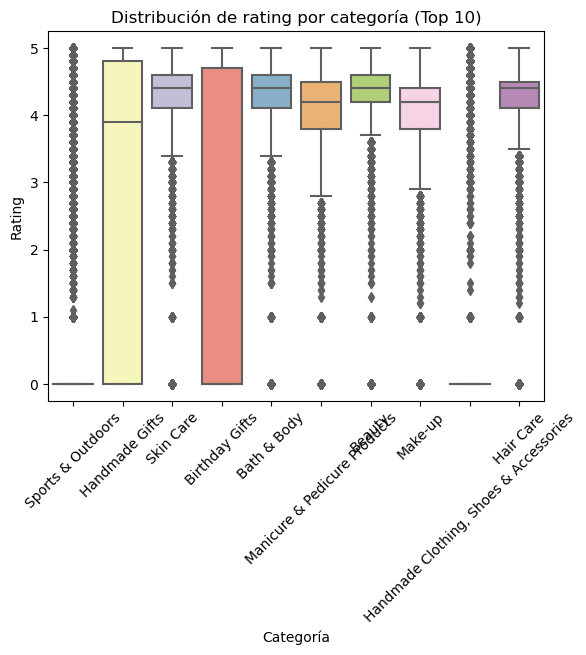

In [23]:
#3. Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

sns.boxplot(x='category', y='stars', data=df_2, palette='Set3')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización
plt.title('Distribución de rating por categoría (Top 10)')
plt.xlabel('Categoría')
plt.ylabel('Rating')
plt.show()

In [24]:
#Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

rating_mediana = price_without_outliers.groupby('category').agg({'stars':'median'})

rating_mediana_mas_alto_por_categoria = rating_mediana.idxmax()
rating_mediana_mas_alto_por_valor = rating_mediana.max()

rating_mediana_mas_alto_por_categoria, rating_mediana_mas_alto_por_valor

(stars    Computer Memory
 dtype: object,
 stars    4.7
 dtype: float64)

In [25]:
#PART 3
#1. Calculate the correlation coefficient between price and stars.

correlation_coefficient = price_without_outliers['price'].corr(price_without_outliers['stars'])
correlation_coefficient

#presentan una correlación negativa débil. Además, a medida que el precio del producto aumenta, las calificaciones tienden a disminuir

-0.0776729987818137

In [26]:
correlation_coefficient_2 = price_without_outliers['price'].corr(price_without_outliers['stars'], method='spearman')
correlation_coefficient_2

#aquí confirmamos que cuando el precio aumenta, las calificaciones tienden a disminuir

-0.06679697280768314

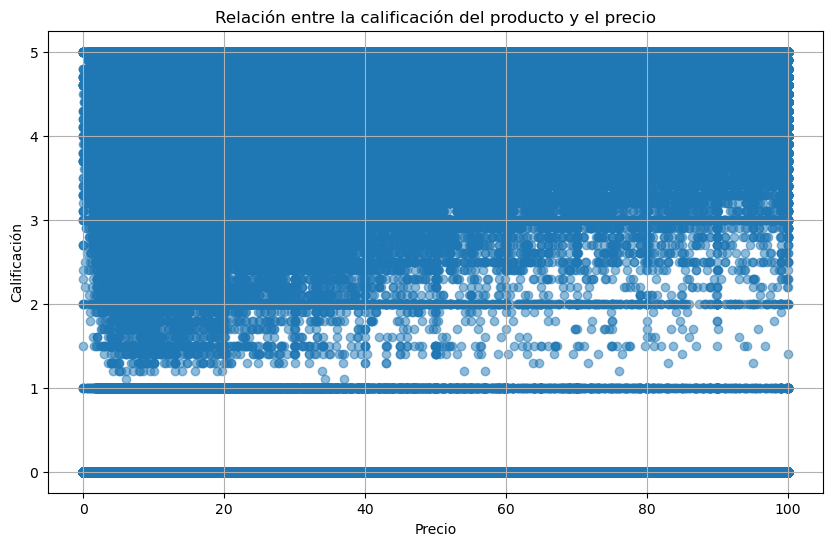

In [27]:
#Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

plt.figure(figsize=(10, 6))
plt.scatter(price_without_outliers['price'], price_without_outliers['stars'], alpha=0.5)
plt.title('Relación entre la calificación del producto y el precio')
plt.xlabel('Precio')
plt.ylabel('Calificación')
plt.grid(True)
plt.show()

#no importa el precio, hay muchísima variedad de ratings para productos más baratos y más caros
#no obstante, de 0 a 1 no se puede ratear con decimales y de 1 en adelante sí

In [30]:
#Use a correlation heatmap to visualize correlations between all numerical variables.

numeric_columns = ['stars', 'reviews', 'price', 'boughtInLastMonth']
df_numeric = price_without_outliers[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [31]:
correlation_matrix = df_numeric.corr()

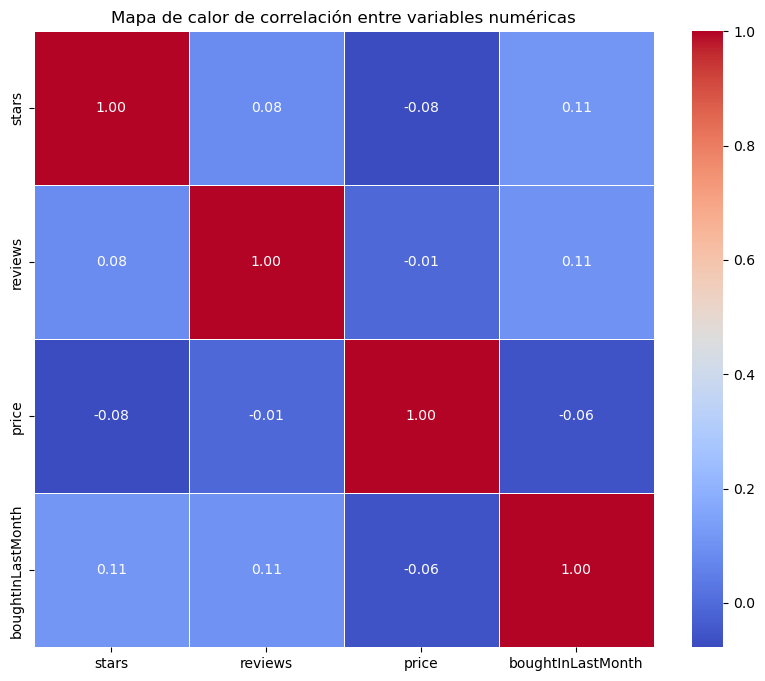

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de calor de correlación entre variables numéricas')
plt.show()

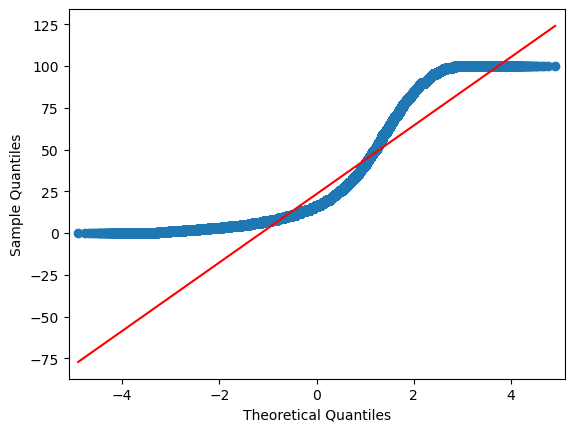

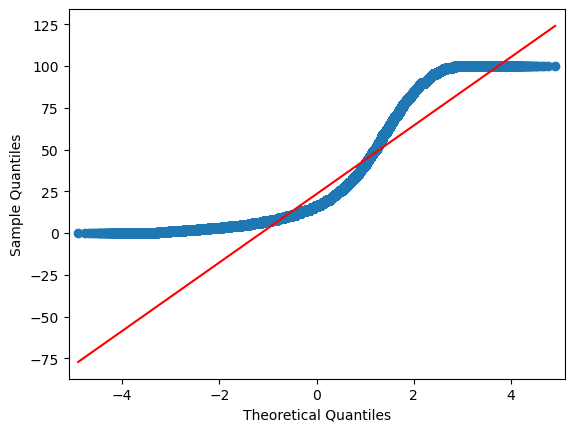

In [33]:
#Examine if product prices typically follow a normal distribution using a QQ plot.

sm.qqplot(price_without_outliers['price'], line= 's')

#no sigue una distribución normal ya que presenta colas muy pronunciadas y alejadas del eje central